По аналогии с кодом с семинара 

Блок меньше: 128 бит (вместо 512).

Раундов меньше: 16 (вместо 64).

Другие константы: взяты из числа π.

Другие функции побитовых операций

In [1]:
# Константы (возьмём дробные части pi)
K = [
    0x243F6A88, 0x85A308D3, 0x13198A2E, 0x03707344,
    0xA4093822, 0x299F31D0, 0x082EFA98, 0xEC4E6C89,
    0x452821E6, 0x38D01377, 0xBE5466CF, 0x34E90C6C,
    0xC0AC29B7, 0xC97C50DD, 0x3F84D5B5, 0xB5470917,
]

In [2]:
H = [
    0x6A09E667,
    0xBB67AE85,
    0x3C6EF372,
    0xA54FF53A,
]

In [3]:
def right_rotate(x, n):
    return ((x >> n) | (x << (32 - n))) & 0xFFFFFFFF

In [4]:
import struct


def sha_lite_compress(chunk, h_values):
    # Разбиваем блок на 4 слова по 32 бита
    w = list(struct.unpack(">4L", chunk)) + [0]*12

    for i in range(4, 16):
        w[i] = (w[i-1] ^ right_rotate(w[i-2], 5) ^ w[i-3] ^ i) & 0xFFFFFFFF

    a, b, c, d = h_values

    for i in range(16):
        f = (a & b) ^ (c & d) 
        temp = (right_rotate(a, 7) + f + w[i] + K[i]) & 0xFFFFFFFF
        a, b, c, d = d, (a + temp) & 0xFFFFFFFF, b, c

    return [
        (h_values[0] + a) & 0xFFFFFFFF,
        (h_values[1] + b) & 0xFFFFFFFF,
        (h_values[2] + c) & 0xFFFFFFFF,
        (h_values[3] + d) & 0xFFFFFFFF,
    ]

In [5]:
def sha_lite(data: str) -> str:
    data_bytes = bytearray(data.encode("utf-8"))
    orig_len = len(data_bytes) * 8

    data_bytes.append(0x80)
    while (len(data_bytes) * 8 + 32) % 128 != 0:  # блок 128 бит
        data_bytes.append(0)
    data_bytes += struct.pack(">I", orig_len & 0xFFFFFFFF)

    h_values = H[:]
    for i in range(0, len(data_bytes), 16):  # блок по 16 байт (128 бит)
        chunk = data_bytes[i:i+16]
        h_values = sha_lite_compress(chunk, h_values)

    return "".join(f"{x:08x}" for x in h_values)

In [6]:
print("sha_lite('hello') =", sha_lite("hello"))
print("sha_lite('hello') =", sha_lite("hello"))
print("sha_lite('Hello') =", sha_lite("Hello"))

sha_lite('hello') = 0ba4eae1cae9d4a6429be2b328905cd2
sha_lite('hello') = 0ba4eae1cae9d4a6429be2b328905cd2
sha_lite('Hello') = d06669e1552fc8a6d9bc58b3e24d61d2


In [7]:
import hashlib
import random
import time

import pandas as pd
import matplotlib.pyplot as plt

from typing import Callable, Dict, Iterable

### seminar

In [14]:
import hashlib
import time
from typing import Callable, Iterable
import pandas as pd
import matplotlib.pyplot as plt

import random


def hash_hex(name: str, s: str) -> str:
    return HASHES_HEX[name](s)

def random_ascii_string(length: int, rng: random.Random = RANDOM) -> str:
    alphabet = [chr(c) for c in range(32, 127)]
    return ''.join(rng.choice(alphabet) for _ in range(length))

def calculate_md5(data):
    return hashlib.md5(data.encode('utf-8')).hexdigest()

def calculate_sha1(data):
    return hashlib.sha1(data.encode('utf-8')).hexdigest()

def calculate_sha256(data):
    return hashlib.sha256(data.encode('utf-8')).hexdigest()

def hex_to_int(h: str) -> int:
    return int(h, 16)

def flip_one_bit_in_text(s: str, rng: random.Random = RANDOM) -> str:
    """Flip a single bit in the UTF-8 bytes of s; if decoding fails, flip a char's LSB instead."""
    b = bytearray(s.encode('utf-8'))
    idx = rng.randrange(len(b))
    bit = 1 << rng.randrange(8)
    b[idx] ^= bit
    try:
        return b.decode('utf-8')
    except UnicodeDecodeError:
        pos = rng.randrange(len(s))
        return s[:pos] + chr(ord(s[pos]) ^ 1) + s[pos+1:]

# ---------- 1) Speed / Throughput ----------
def measure_time(func: Callable[[], None], repeats: int = 3) -> float:
    best = float('inf')
    for _ in range(repeats):
        t0 = time.perf_counter()
        func()
        best = min(best, time.perf_counter() - t0)
    return best

def benchmark_speed(
    names: Iterable[str] = ("sha_lite", "md5", "sha1", "sha256"),
    sizes: Iterable[int] = [i for i in range(1, 10_000, 100)],
    n_per_size: int = 100,
):
    rows = []
    for name in names:
        for L in sizes:
            strings = [random_ascii_string(L) for _ in range(n_per_size)]
            def run():
                acc = 0
                for s in strings:
                    acc ^= hex_to_int(hash_hex(name, s))
                return acc
            elapsed = measure_time(run, repeats=3)
            total_bytes = n_per_size * L
            ns_per_byte = (elapsed / total_bytes) * 1e9
            mbps = (total_bytes / elapsed) / (1024 * 1024)
            rows.append((name, L, ns_per_byte, mbps, elapsed))
    return pd.DataFrame(rows, columns=["hash","size_bytes","ns_per_byte","MB_per_s", "elapsed"])

def plot_speed(df: pd.DataFrame):
    # MB/s vs size
    plt.figure()
    for name, sub in df.groupby("hash"):
        sub = sub.sort_values("size_bytes")
        plt.plot(sub["size_bytes"], sub["MB_per_s"], marker="o", label=name)
    plt.xlabel("Input size (bytes)")
    plt.ylabel("MB/s")
    plt.title("Speed: throughput vs input size")
    plt.legend()
    plt.grid(True)

    # elapsed vs size
    plt.figure()
    for name, sub in df.groupby("hash"):
        sub = sub.sort_values("size_bytes")
        plt.plot(sub["size_bytes"], sub["elapsed"], marker="o", label=name)
    plt.xlabel("Input size (bytes)")
    plt.ylabel("NS")
    plt.title("Speed: throughput vs input size")
    plt.legend()
    plt.grid(True)
    
SEED = 42
RANDOM = random.Random(SEED)

HASHES_HEX: Dict[str, Callable[[str], str]] = {
    "sha_lite": sha_lite,
    "md5": calculate_md5,
    "sha1": calculate_sha1,
    "sha256": calculate_sha256,
}

In [15]:
def hamming_distance(a: int, b: int) -> int:
    return (a ^ b).bit_count()

def hamming_distance_hex(h1: str, h2: str) -> int:
    """Hamming distance between two equal-width hex strings."""
    return hamming_distance(int(h1, 16), int(h2, 16))

In [16]:
# ---------- 2) Avalanche Effect ----------

def _digest_bits_native(name: str) -> int:
    """Infer native bit-width from hex digest length."""
    hx = hash_hex(name, "")
    return len(hx) * 4

def test_avalanche(
    names: Iterable[str] = ("sha_lite", "md5", "sha1", "sha256"),
    input_len: int = 256,
    samples: int = 10_000,
) -> pd.DataFrame:
    """
    Measure Avalanche Effect for each hash using its *native* output width.
    Returns a DataFrame with: hash, bits, avg_flipped_bits, ideal, ratio.
    """
    rng = RANDOM
    rows = []
    for name in names:
        bits = _digest_bits_native(name)
        total = 0
        for _ in range(samples):
            s = random_ascii_string(input_len)
            s_flipped = flip_one_bit_in_text(s)

            # Compute Hamming distance between native-width outputs
            h1 = int(hash_hex(name, s), 16)
            h2 = int(hash_hex(name, s_flipped), 16)
            total += hamming_distance(h1, h2)

        avg = total / samples
        ideal = bits / 2.0
        share = avg / bits
        ratio = avg / ideal if ideal else float('nan')
        rows.append((name, bits, avg, ideal, ratio, share))

    return pd.DataFrame(rows, columns=["hash", "bits", "avg_flipped_bits", "ideal", "ratio", "share"])

def plot_avalanche(df: pd.DataFrame):
    """
    Bar chart of average flipped bits per hash with per-hash ideal markers (bits/2).
    """
    plt.figure()
    dfp = df.sort_values("avg_flipped_bits")
    x_labels = list(dfp["hash"])
    y_vals = list(dfp["share"])
    ideals = [0.5] * len(y_vals)

    # Bars: observed averages
    plt.bar(x_labels, y_vals)
    # Overlay per-hash ideal markers
    plt.plot(x_labels, ideals, marker="o", linestyle="none")

    plt.ylabel("share (avg flipped / bits)")
    plt.title("Avalanche Effect")
    plt.grid(True, axis='y')

In [24]:
# ---------- 3) Uniformity (χ² over buckets) ----------
import math


def truncate_int(x: int, bits: int) -> int:
    return x & ((1 << bits) - 1) if bits < 256 else x

def hash_as_int_trunc(name: str, s: str, out_bits: int) -> int:
    return truncate_int(hex_to_int(hash_hex(name, s)), out_bits)

def chi_square_uniformity(
    names: Iterable[str] = ("sha_lite", "md5", "sha1", "sha256"),
    out_bits: int = 64,
    bucket_bits: int = 11,
    N: int = 1_000_000,
):
    rng = RANDOM
    B = 1 << bucket_bits
    expected = N / B
    rows = []
    for name in names:
        counts = [0] * B
        for _ in range(N):
            s = random_ascii_string(32)
            h = hash_as_int_trunc(name, s, out_bits)
            counts[h & (B - 1)] += 1
        chi2 = sum(((c - expected) ** 2) / expected for c in counts)
        max_dev = max(abs(c - expected) for c in counts)
        rows.append((name, B, N, chi2, max_dev))
    return pd.DataFrame(rows, columns=["hash","buckets","samples","chi2","max_abs_dev"])

def plot_uniformity(df: pd.DataFrame, title_suffix: str = "low bits"):
    """
    Reading guide:
      - Bars near 1 and inside the shaded band look good.
      - Large |z| (≈ > 2) may indicate bias; consider more samples or test high bits.
    """
    if df.empty:
        raise ValueError("Empty dataframe passed to plot_uniformity")

    # Shared parameters (assumed identical across rows)
    B = int(df["buckets"].iloc[0])
    N = int(df["samples"].iloc[0])
    dof = B - 1

    # Normalize chi² and compute z-scores under H0 (uniform):
    # E[chi²] = dof, Var[chi²] = 2*dof  => sd = sqrt(2*dof)
    chi2_mean = dof
    chi2_sd = math.sqrt(2.0 * dof)

    dfp = df.copy()
    dfp["chi2_per_df"] = dfp["chi2"] / dof
    dfp["z_score"] = (dfp["chi2"] - chi2_mean) / chi2_sd

    # For chi²/dof the sd is sqrt(2/dof)
    sd_norm = math.sqrt(2.0 / dof)
    band_lo, band_hi = 1 - 2 * sd_norm, 1 + 2 * sd_norm  # ±2σ band

    # --- Single figure ---
    plt.figure()
    df_sorted = dfp.sort_values("chi2_per_df")
    x = list(df_sorted["hash"])
    y = list(df_sorted["chi2_per_df"])
    z = list(df_sorted["z_score"])

    # Bars: chi²/dof
    plt.bar(x, y)

    # Ideal line and ±2σ band
    plt.axhline(1.0, linestyle="--")
    plt.fill_between([-0.5, len(x) - 0.5], band_lo, band_hi, alpha=0.15)

    # Annotate z-scores above bars
    for xi, yi, zi in zip(range(len(x)), y, z):
        plt.text(xi, yi, f"z={zi:.2f}", ha="center", va="bottom")

    plt.ylabel("chi² / dof  (ideal ≈ 1)")
    plt.title(f"Uniformity (χ² normalized) — {title_suffix}")
    plt.grid(True, axis="y")

In [18]:
# ---------- 4) Collisions under truncation ----------
def collision_test(
    names: Iterable[str] = ("sha_lite", "md5", "sha1", "sha256"),
    out_bits: int = 32,
    N: int = 500_000,
):
    rng = RANDOM
    rows = []
    for name in names:
        seen = set()
        collisions = 0
        for _ in range(N):
            s = random_ascii_string(32)
            h = hash_as_int_trunc(name, s, out_bits)
            if h in seen: collisions += 1
            else: seen.add(h)
        expected = (N * (N - 1)) / (2 * (1 << out_bits))
        rows.append((name, out_bits, N, collisions, expected))
    return pd.DataFrame(rows, columns=["hash","bits","N","collisions","expected_birthday"])

def plot_collisions(df: pd.DataFrame):
    plt.figure()
    df_sorted = df.sort_values("collisions")
    plt.bar(df_sorted["hash"], df_sorted["collisions"])
    expected = df_sorted["expected_birthday"].iloc[0]
    plt.axhline(expected, linestyle="--")
    plt.ylabel("Observed collisions")
    plt.title("Collisions under truncation")
    plt.text(0.5, expected, f'Expected ≈ {expected:.1f}', va='bottom')
    plt.grid(True, axis='y')

In [32]:
# ---------- 5) Bit balance ----------
def bit_balance(
    names: Iterable[str] = ("sha_lite", "md5", "sha1", "sha256"),
    out_bits: int = 64,
    N: int = 500_000,
):
    rng = RANDOM
    rows = []
    for name in names:
        ones = [0] * out_bits
        for _ in range(N):
            s = random_ascii_string(48, rng)
            h = hash_as_int_trunc(name, s, out_bits)
            for b in range(out_bits):
                ones[b] += (h >> b) & 1
        freqs = [x / N for x in ones]
        sum_dev = sum(abs(f) for f in freqs) / out_bits
        avg_dev = sum(abs(f - 0.5) for f in freqs) / out_bits
        worst_dev = max(abs(f - 0.5) for f in freqs)
        rows.append((name, out_bits, N, avg_dev, worst_dev, sum_dev))
    return pd.DataFrame(rows, columns=["hash","bits","N","avg_abs_dev","worst_abs_dev", "sum_dev"])

def plot_bit_balance(df: pd.DataFrame):
    plt.figure()
    df_sorted = df.sort_values("avg_abs_dev")
    plt.bar(df_sorted["hash"], df_sorted["avg_abs_dev"])
    plt.ylabel("Avg |p(bit=1) - 0.5| (lower is better)")
    plt.title("Bit balance")
    plt.grid(True, axis='y')

### banchmarks

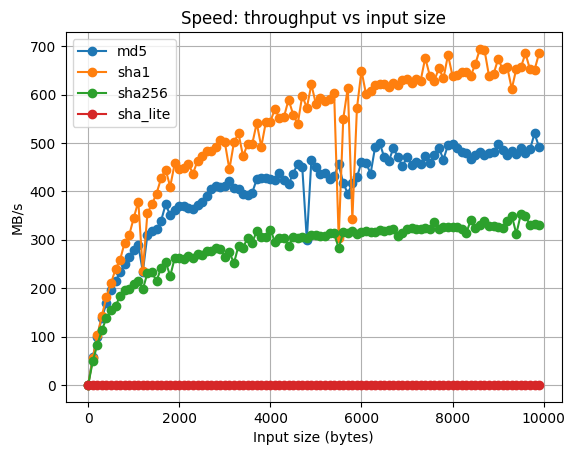

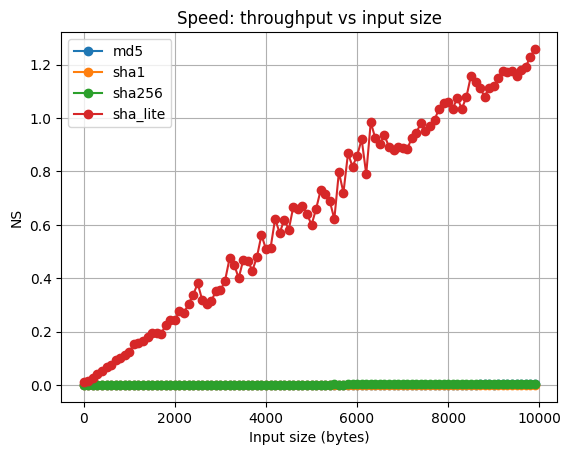

In [19]:
df_speed = benchmark_speed()
plot_speed(df_speed)

In [20]:
df_avalanche = test_avalanche()

In [21]:
df_avalanche

,hash,bits,avg_flipped_bits,ideal,ratio,share
0,sha_lite,128,63.9770,64.0,0.999641,0.499820
1,md5,128,63.9561,64.0,0.999314,0.499657
2,sha1,160,79.9028,80.0,0.998785,0.499393
3,sha256,256,127.9474,128.0,0.999589,0.499795


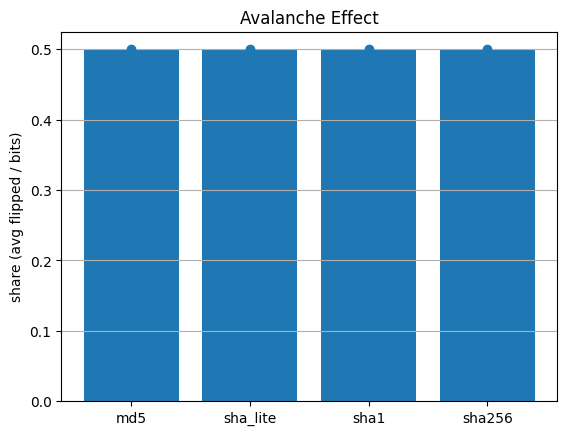

In [22]:
plot_avalanche(df_avalanche)

In [25]:
df_uniform = chi_square_uniformity()
df_uniform

,hash,buckets,samples,chi2,max_abs_dev
0,sha_lite,2048,1000000,2042.523648,86.71875
1,md5,2048,1000000,2002.669568,74.71875
2,sha1,2048,1000000,2007.072768,75.28125
3,sha256,2048,1000000,2034.765824,75.28125


In [26]:
df_coll = collision_test()

In [27]:
df_coll

,hash,bits,N,collisions,expected_birthday
0,sha_lite,32,500000,24,29.103772
1,md5,32,500000,29,29.103772
2,sha1,32,500000,33,29.103772
3,sha256,32,500000,31,29.103772


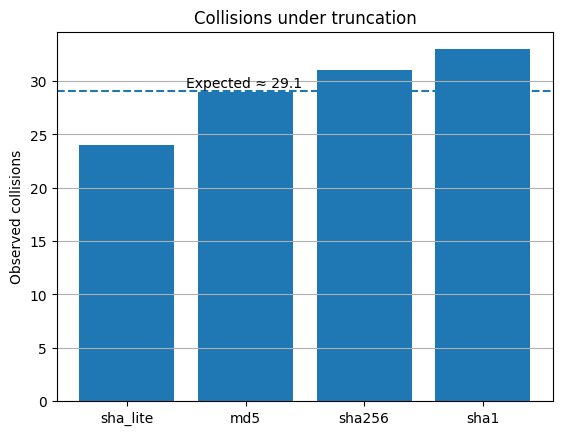

In [28]:
plot_collisions(df_coll)

In [33]:
df_balance = bit_balance()

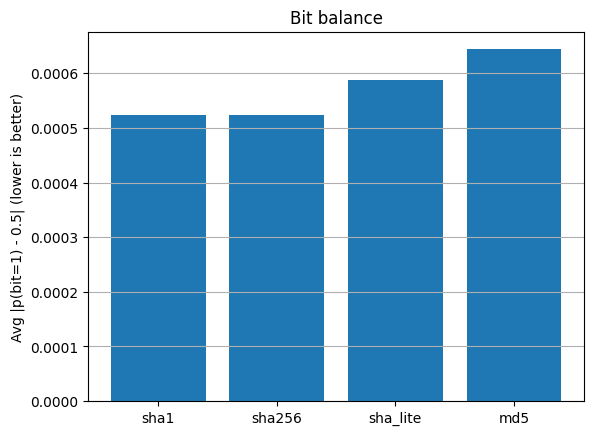

In [34]:
plot_bit_balance(df_balance)

Судя по графикам, алгоритм крайне быстрый в терминах MB/s, но при этом показывает линейное увеличение времени обработки в наносекундах (NS). sha_lite жертвует криптостойкостью ради скорости.

при этом он даёт также мало колизий
